In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted


class JamesSteinEstimator(BaseEstimator, TransformerMixin):
    """
    James-Stein Estimator for shrinking estimates towards a target.

    This estimator shrinks input estimates towards a specified target to potentially
    reduce the Mean Squared Error (MSE) in high-dimensional settings.

    Parameters
    ----------
    shrinkage_target : array-like or scalar, default=0
        The target towards which the estimates are shrunk. If scalar, the same
        target is applied to all dimensions. If array-like, it must have the
        same number of dimensions as the input data.

    sigma : float, default=1.0
        The known standard deviation of the normal distributions from which
        the estimates are drawn.

    Attributes
    ----------
    p_ : int
        The number of dimensions/features.
    """

    def __init__(self, shrinkage_target=0, sigma=1.0):
        self.shrinkage_target = shrinkage_target
        self.sigma = sigma

    def fit(self, X, y=None):
        """
        Fit the James-Stein estimator to the data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input estimates to be shrunk.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        X = check_array(X, ensure_2d=True)
        self.p_ = X.shape[1]

        if self.p_ < 3:
            raise ValueError("Dimension must be at least 3 for the James-Stein estimator.")

        # If shrinkage_target is scalar, broadcast it to match the number of features
        if np.isscalar(self.shrinkage_target):
            self.shrinkage_target_ = np.full(self.p_, self.shrinkage_target)
        else:
            self.shrinkage_target_ = np.asarray(self.shrinkage_target)
            if self.shrinkage_target_.shape[0] != self.p_:
                raise ValueError("shrinkage_target must have the same number of dimensions as the input data.")

        return self

    def transform(self, X):
        """
        Apply the James-Stein shrinkage to the input data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input estimates to be shrunk.

        Returns
        -------
        X_transformed : array-like of shape (n_samples, n_features)
            The shrunk estimates.
        """
        check_is_fitted(self, 'p_')
        X = check_array(X, ensure_2d=True)

        if X.shape[1] != self.p_:
            raise ValueError(f"Input data must have {self.p_} features, got {X.shape[1]}.")

        # Compute the squared Euclidean norm of (X - shrinkage_target)
        squared_norms = np.sum((X - self.shrinkage_target_)**2, axis=1)

        # Compute shrinkage factors
        shrinkage_factors = ((self.p_ - 2) * (self.sigma ** 2)) / squared_norms
        shrinkage_factors = np.maximum(shrinkage_factors, 0)  # Ensure non-negative

        # Apply shrinkage towards the target
        # Reshape shrinkage_factors for broadcasting
        shrinkage_factors = shrinkage_factors[:, np.newaxis]
        X_transformed = self.shrinkage_target_ + (1 - shrinkage_factors) * (X - self.shrinkage_target_)

        return X_transformed

In [2]:
def simulate_james_stein(parallel_runs=10000, dimension=5, theta=None, sigma=1.0):
    """
    Simulates the James-Stein estimator and compares it with the sample mean estimator.

    Parameters:
    - parallel_runs: int, number of simulation runs
    - dimension: int, the dimensionality of the mean vector
    - theta: np.array or None, the true mean vector. If None, defaults to a vector of ones.
    - sigma: float, the standard deviation of the normal distributions

    Returns:
    - mse_mean: float, Mean Squared Error of the sample mean estimator
    - mse_js: float, Mean Squared Error of the James-Stein estimator
    """
    if theta is None:
        theta = np.ones(dimension)

    # Generate all samples at once for efficiency
    samples = np.random.normal(loc=theta, scale=sigma, size=(parallel_runs, dimension))

    # Sample mean estimator (each sample is one observation)
    mean_estimates = samples

    # Initialize and fit the James-Stein estimator
    js_estimator = JamesSteinEstimator(shrinkage_target=0, sigma=sigma)
    js_estimator.fit(samples)
    js_estimates = js_estimator.transform(samples)

    # Compute squared errors for both estimators
    squared_errors_mean = np.sum((mean_estimates - theta)**2, axis=1)
    squared_errors_js = np.sum((js_estimates - theta)**2, axis=1)

    # Compute Mean Squared Errors
    mse_mean = np.mean(squared_errors_mean)
    mse_js = np.mean(squared_errors_js)

    return mse_mean, mse_js, squared_errors_mean, squared_errors_js

Number of simulations: 10000
Dimension (p): 5
True mean vector (theta): [3.  4.  2.  2.5 5. ]
Standard deviation (sigma): 1.0

Mean Squared Error of Sample Mean Estimator: 4.9405
Mean Squared Error of James-Stein Estimator: 4.8013

Improvement: 0.1392 lower MSE with James-Stein estimator.



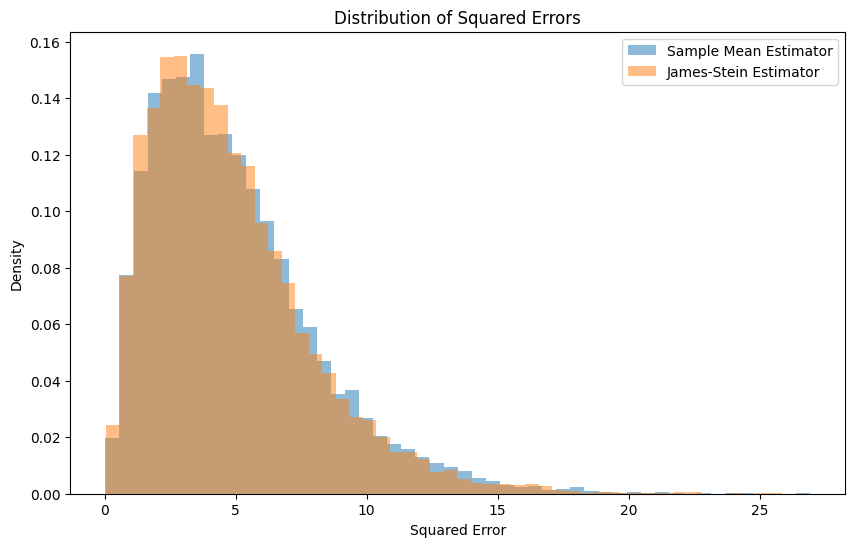

In [3]:
def main():
    # Simulation parameters
    parallel_runs = 10000
    dimension = 5  # Must be >=3 to observe the James-Stein phenomenon
    theta = np.array([3, 4, 2, 2.5, 5])  # True mean vector
    sigma = 1.0  # Standard deviation

    # Run simulation
    mse_mean, mse_js, squared_errors_mean, squared_errors_js = simulate_james_stein(
        parallel_runs, dimension, theta, sigma
    )

    print(f"Number of simulations: {parallel_runs}")
    print(f"Dimension (p): {dimension}")
    print(f"True mean vector (theta): {theta}")
    print(f"Standard deviation (sigma): {sigma}\n")

    print(f"Mean Squared Error of Sample Mean Estimator: {mse_mean:.4f}")
    print(f"Mean Squared Error of James-Stein Estimator: {mse_js:.4f}")
    print(f"\nImprovement: {mse_mean - mse_js:.4f} lower MSE with James-Stein estimator.\n")

    # Visualization of the distribution of squared errors
    plt.figure(figsize=(10, 6))
    plt.hist(squared_errors_mean, bins=50, alpha=0.5, label='Sample Mean Estimator', density=True)
    plt.hist(squared_errors_js, bins=50, alpha=0.5, label='James-Stein Estimator', density=True)
    plt.title('Distribution of Squared Errors')
    plt.xlabel('Squared Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()